In [1]:
!pip install albumentations --user > /dev/null 2>&1

In [2]:
!pip install pretrainedmodels --user > /dev/null 2>&1

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2
import albumentations
from albumentations import torch as AT
import pretrainedmodels
import csv


In [21]:
train_df = pd.read_csv("./data/train.csv")
train_df.head()
test_df = pd.read_csv("./data/test.csv")
test_df.head()

,Image,Id
0,cfb8c68dc.jpg,new_whale
1,66bf04895.jpg,w_b27b6c6
2,d6a92a7f9.jpg,new_whale
3,a37e5cc98.jpg,new_whale
4,2a215f11e.jpg,new_whale


In [22]:
print(f"There are {len(os.listdir('./data/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('./data/test'))} images in test dataset with {test_df.Id.nunique()} unique classes.")
      

There are 20289 images in train dataset with 4571 unique classes.
There are 5073 images in test dataset with 1956 unique classes.


In [23]:
train_df.Id.value_counts().head()

new_whale    7728
w_23a388d      60
w_9b5109b      55
w_0369a5c      54
w_9c506f6      52
Name: Id, dtype: int64

In [24]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2182 classes with 1 samples in train data.
There are 1085 classes with 2 samples in train data.
There are 441 classes with 3 samples in train data.


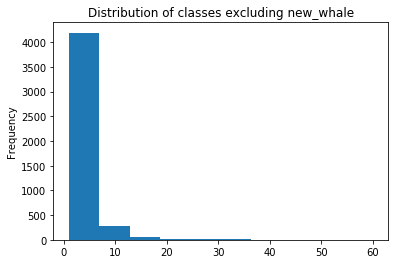

In [25]:
train_df.Id.value_counts()[1:].plot(kind='hist');
plt.title('Distribution of classes excluding new_whale');

In [26]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])


In [27]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [28]:
y, le = prepare_labels(train_df['Id'])
y_test, le_test = prepare_labels(test_df['Id'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [64]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None
                ):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((1956,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]
        

In [65]:
train_dataset = WhaleDataset(datafolder='./data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='./data/test/', datatype='test', transform=data_transforms_test)


In [66]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./data/train/')))))
batch_size = 512
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)


In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        self.fc2 = nn.Linear(1024, 4571)

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [68]:
model_conv = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [69]:
model_conv.cuda()
n_epochs = 10
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(train_loader):
        print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

# sub = pd.read_csv('../input/sample_submission.csv')

# model_conv.eval()
# for (data, target, name) in test_loader:
#     data = data.cuda()
#     output = model_conv(data)
#     output = output.cpu().detach().numpy()
#     for i, (e, n) in enumerate(list(zip(output, name))):
#         sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
# sub.to_csv('basic_model.csv', index=False)


Tue May 21 16:22:48 2019 Epoch: 1
0


RuntimeError: CUDA out of memory. Tried to allocate 3.01 GiB (GPU 0; 10.91 GiB total capacity; 10.05 GiB already allocated; 161.38 MiB free; 8.51 MiB cached)

# pretrain

In [53]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None
                ):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((1956,))

        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [54]:
data_transforms = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(160, 320),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

train_dataset = WhaleDataset(datafolder='./data/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
##test_set = WhaleDataset(datafolder='../input/test/', datatype='test', transform=data_transforms_test)

train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./data/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./data/test')))))
batch_size = 10
num_workers = 2
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, num_workers=num_workers)


In [55]:

# model_conv = torchvision.models.resnet101(pretrained=True)
# for i, param in model_conv.named_parameters():
#     param.requires_grad = False

In [56]:
# final_layer = nn.Sequential(OrderedDict([
#                            ('fc1', nn.Linear(2048, 1024)),
#                            ('relu', nn.ReLU()),
#                            ('dropout', nn.Dropout(0.1)),
#                            ('fc2', nn.Linear(1024, 4251)),
#                            ]))
# model_conv.fc = final_layer
# model_conv.fc = nn.Linear(2048, 4251)

In [61]:
model_conv = pretrainedmodels.resnext101_64x4d()
model_conv.avg_pool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4571)


In [62]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [63]:
n_epochs = 4
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    

    for batch_i, (data, target) in enumerate(train_loader):
        # print(f'Batch {batch_i} of 50')
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    exp_lr_scheduler.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

Tue May 21 16:22:31 2019 Epoch: 1


RuntimeError: CUDA out of memory. Tried to allocate 7.88 MiB (GPU 0; 10.91 GiB total capacity; 10.14 GiB already allocated; 1.38 MiB free; 8.50 MiB cached)